In [1]:
# Somme parziali della serie ∑ 1/k^2 in singola precisione (Float32)
function sum_single_precision(N_min::Int, N_max::Int, step::Int)
    
    x_axis = collect(N_min:step:N_max)
    
    values = zeros(Float32, N_max + 1)  # values[1] = 1/1^2, ..., values[N_max] = 1/N_max^2
    for i in 1:N_max
        values[i] = Float32(1 / (i^2))
    end

    sum_crescente   = zeros(Float32, length(x_axis))
    sum_decrescente = zeros(Float32, length(x_axis))

    # Nota: in Python si usa m = 0..n con indexing 0-based.
    # In Julia (1-based) usiamo m = 0..n e accediamo a values[m+1] e values[n-m+1].
    @inbounds for (i, n) in pairs(x_axis)
        sc = 0f0
        sd = 0f0
        for m in 0:n
            sc += values[m + 1]
            sd += values[n - m + 1]
        end
        sum_crescente[i]   = sc
        sum_decrescente[i] = sd
    end

    return sum_crescente, sum_decrescente, x_axis
end

# Somme parziali in doppia precisione (Float64), con n presi da un vettore dato
function sum_double_precision_fixed(n_values::AbstractVector{<:Integer})
    sum_crescente   = zeros(Float64, length(n_values))
    sum_decrescente = zeros(Float64, length(n_values))

    @inbounds for (i, n) in pairs(n_values)
        s1 = 0.0
        for k in 1:n           # crescente: da 1 a n
            s1 += 1.0 / (k^2)
        end
        sum_crescente[i] = s1

        s2 = 0.0
        for k in n:-1:1        # decrescente: da n a 1
            s2 += 1.0 / (k^2)
        end
        sum_decrescente[i] = s2
    end

    return sum_crescente, sum_decrescente
end

# ------------------- Uso come nello script Python -------------------

# Calcolo delle somme (Float32)
a, b, c = 1000, 10000, 50
sum_crescente_32, sum_decrescente_32, x_axis_1 = sum_single_precision(a, b, c)

# Usa valori più ragionevoli per evitare problemi di memoria (Float64)
# np.logspace(7.5, 8.5, 30, dtype=int)  ->  10 .^ range(...), poi arrotondo a Int
x_axis_2 = Int.(round.(10 .^ range(7.5, stop=8.5, length=30)))
sum_crescente_64, sum_decrescente_64 = sum_double_precision_fixed(x_axis_2)

# Calcolo errori rispetto a π^2/6
lim = (π^2) / 6
err_crescente_32   = abs.(Float64.(sum_crescente_32)   .- lim)
err_decrescente_32 = abs.(Float64.(sum_decrescente_32) .- lim)
err_crescente_64   = abs.(sum_crescente_64   .- lim)
err_decrescente_64 = abs.(sum_decrescente_64 .- lim)

# (facoltativo) stampa rapida di controllo
println(("n32_min,max = ", first(x_axis_1), last(x_axis_1)))
println(("n64_min,max = ", minimum(x_axis_2), maximum(x_axis_2)))
println(("err32 cresc/decresc (ultimi): ", err_crescente_32[end], ", ", err_decrescente_32[end]))
println(("err64 cresc/decresc (ultimi): ", err_crescente_64[end], ", ", err_decrescente_64[end]))


("n32_min,max = ", 1000, 10000)
("n64_min,max = ", 31622777, 316227766)
("err32 cresc/decresc (ultimi): ", 0.0002087441248377342, ", ", 0.00010002525276742169)
("err64 cresc/decresc (ultimi): ", 9.013651380840315e-9, ", ", 3.1622775509276835e-9)


In [2]:
using Pkg
Pkg.add("Plots")


   Resolving package versions...
     Project No packages added to or removed from `C:\Users\alice\.julia\environments\v1.12\Project.toml`
    Manifest No packages added to or removed from `C:\Users\alice\.julia\environments\v1.12\Manifest.toml`


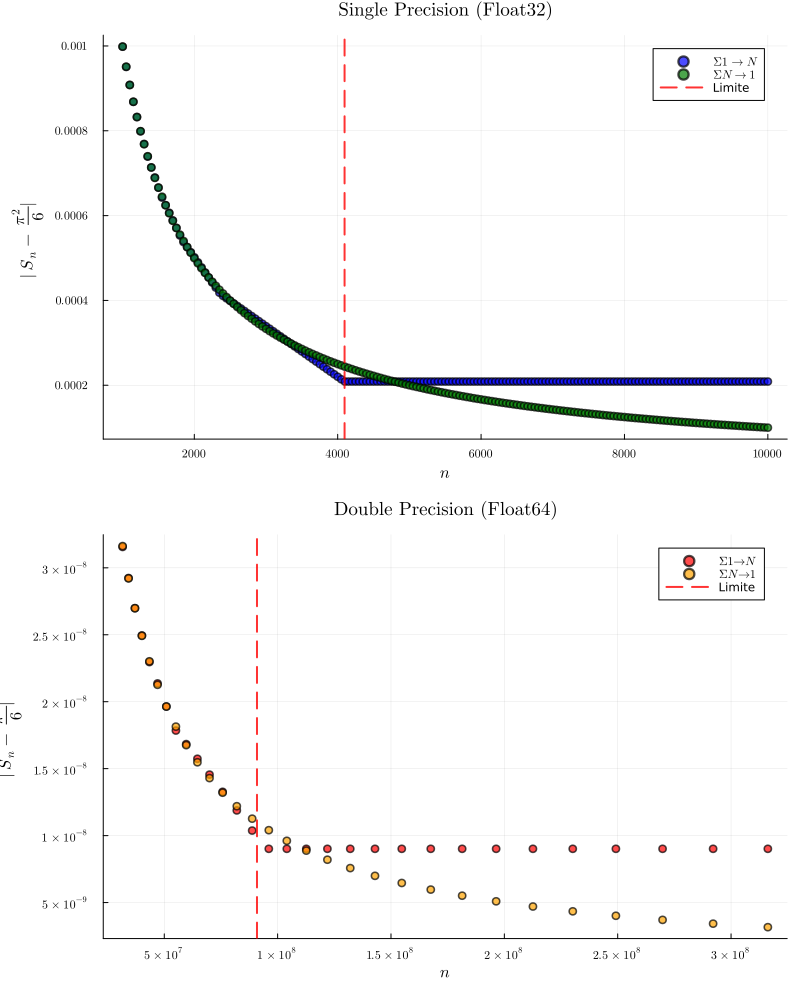

In [14]:
using Plots, LaTeXStrings
gr()# PRIMO GRAFICO (Float32)
p1 = plot(
    x_axis_1, err_crescente_32,
    seriestype = :scatter,
    label = L"$\Sigma 1 \rightarrow N$",
    color = :blue,
    alpha = 0.7,
)
plot!(p1, x_axis_1, err_decrescente_32,
    seriestype = :scatter,
    label = L"$\Sigma N \rightarrow 1$",
    color = :green,
    alpha = 0.7,
)
plot!(p1, 
      xticks = ([2000, 4000, 6000, 8000, 10000], [L"$2000$", L"$4000$", L"$6000$", L"$8000$", L"$10000$"]),
      yticks = ([0.0002, 0.0004, 0.0006, 0.0008, 0.001], [L"$0.0002$", L"$0.0004$", L"$0.0006$", L"$0.0008$", L"$0.001$"]))

# Retta verticale con stile
vline!([4096], 
       color = :red, 
       linestyle = :dash, 
       linewidth = 2, 
       alpha = 0.8,
       label = "Limite")
xlabel!(p1, L"n")
ylabel!(p1, L"|S_n - \frac{\pi^2}{6}|")
title!(p1, "Single Precision (Float32)", titlefont = ("Computer Modern", 12, :bold))

# SECONDO GRAFICO (Float64)
p2 = plot(
    x_axis_2, err_crescente_64,
    seriestype = :scatter,
    label = L"Σ 1→N",
    color = :red,
    alpha = 0.7,
)
plot!(p2, x_axis_2, err_decrescente_64,
    seriestype = :scatter,
    label = L"$Σ N→1$",
    color = :orange,
    alpha = 0.7,
)
plot!(p2, 
      xticks = ([5e7, 1e8, 1.5e8, 2e8, 2.5e8, 3e8], [L"$5 \times 10^{7}$", L"$1 \times 10^{8}$", L"$1.5 \times 10^{8}$", L"$2 \times 10^{8}$", L"$2.5 \times 10^{8}$", L"$3 \times 10^{8}$"]),
      yticks = ([5e-9, 1e-8, 1.5e-8, 2e-8, 2.5e-8, 3e-8], [L"$5 \times 10^{-9}$", L"$1 \times 10^{-8}$", L"$1.5 \times 10^{-8}$", L"$2 \times 10^{-8}$", L"$2.5 \times 10^{-8}$", L"$3 \times 10^{-8}$"]))

# Retta verticale con stile
vline!([90896724], 
       color = :red, 
       linestyle = :dash, 
       linewidth = 2, 
       alpha = 0.8,
       label = "Limite")
xlabel!(p2, L"$n$")
ylabel!(p2, L"$|S_n - \frac{\pi^2}{6}|$")
title!(p2, "Double Precision (Float64)", titlefont = ("Computer Modern", 12, :bold))

# COMBINAZIONE
final_plot = plot(p1, p2, layout = (2, 1), size = (800, 1000))
display(final_plot)

In [ ]:

plot!(p2, 
      xticks = ([5e7, 1e8, 1.5e8, 2e8, 2.5e8, 3e8], [L"$5 \times 10^{7}$", L"$1 \times 10^{8}$", L"$1.5 \times 10^{8}$", L"$2 \times 10^{8}$", L"$2.5 \times 10^{8}$", L"$3 \times 10^{8}$"]),
      yticks = ([0.002, [L"$5 \times 10^{-9}$", L"$1 \times 10^{-8}$", L"$1.5 \times 10^{-8}$", L"$2 \times 10^{-8}$", L"$2.5 \times 10^{-8}$", L"$3 \times 10^{-8}$"]))


In [ ]:
plot!(p1, 
      xticks = ([2000, 4000, 6000, 8000, 10000], [L"$2000$", L"$4000$", L"$6000$", L"$8000$", L"$10000$"]),
      yticks = ([0.0002, 0.004, 0.0006, 0.0008, 0.001], [L"$0.0002$", L"$0.004$", L"$0.0006$", L"$0.0008$", L"$0.001$"]))
